In [1]:
import pandas as pd
import numpy as np
import os
from datetime import datetime
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import plotly.express as px


In [32]:
# os.chdir("/Users/mckenziehumann/Dropbox (MIT)/Fall 2021/GIS/Final Project/bluebikes/")
station_data = pd.read_csv("../../data/bluebikes/station_statuses.csv")
station_info = pd.read_csv("../../data/bluebikes/all_station_info.csv")[['station_id','legacy_id','short_name','name','lat','lon','opened']]
trips = pd.read_csv("../../data/bluebikes/202110-blueblikes-tripdata.csv")


In [35]:
station_info['opened'] = pd.to_datetime(station_info['opened'])
station_info['new'] = station_info['opened'] > '2018-01-01'

In [37]:
station_data = station_data.merge(station_info,on='station_id',how='outer')


In [38]:
station_data = station_data.loc[station_data['station_status']=='active'].copy()
station_data['last_updated'] = pd.to_datetime(station_data['last_updated'])
station_data['dock_capacity'] = station_data['num_bikes_available'] / (station_data['num_docks_available'] + station_data['num_bikes_available'])

In [39]:
station_data['datetime'] = station_data['last_updated'].round('60min')
station_data['day'] = station_data['datetime'].dt.day_name()
station_data['time'] = [datetime.time(d) for d in station_data['datetime']] 
station_data['date'] = station_data['datetime'].dt.date

In [40]:
station_data.station_id.unique().shape

(403,)

In [41]:
station_data.time.value_counts()

14:00:00    4337
15:00:00    4336
21:00:00    4336
22:00:00    4336
23:00:00    4336
00:00:00    4336
19:00:00    4335
16:00:00    4335
17:00:00    4335
18:00:00    4335
20:00:00    4335
06:00:00    3949
07:00:00    3949
03:00:00    3949
05:00:00    3949
08:00:00    3949
04:00:00    3949
01:00:00    3949
02:00:00    3949
09:00:00    3947
10:00:00    3945
11:00:00    3943
12:00:00    3940
13:00:00    3937
Name: time, dtype: int64

In [42]:
station_data['date']

0         2021-11-10
1         2021-11-12
2         2021-11-17
3         2021-11-16
4         2021-11-16
             ...    
105415    2021-11-17
105416    2021-11-07
105417    2021-11-09
105418    2021-11-09
105419    2021-11-14
Name: date, Length: 98996, dtype: object

In [43]:
weekends = ['Saturday', 'Sunday']
station_data['i_weekend'] = (station_data['day'].isin(weekends))
station_data['i_weekend'].loc[station_data['date'] == '2021-11-11'] = True

/Users/mckenziehumann/opt/anaconda3/envs/BigData21/lib/python3.9/site-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [44]:
station_data[['i_weekend','day']].value_counts()

i_weekend  day      
False      Monday       19057
           Tuesday      18974
           Wednesday    18857
True       Sunday       13438
False      Thursday      9840
           Friday        9422
True       Saturday      9408
dtype: int64

In [45]:
avg_day_dock_capacity = station_data.groupby(['short_name','time','i_weekend'])['dock_capacity'].mean().to_frame(name='dock_capacity').reset_index()


In [46]:
weekend_dock_capacity = avg_day_dock_capacity.loc[avg_day_dock_capacity['i_weekend']][['short_name','time','dock_capacity']]
weekday_dock_capacity = avg_day_dock_capacity.loc[~(avg_day_dock_capacity['i_weekend'])][['short_name','time','dock_capacity']]
                                                

In [47]:
weekday_dock_capacity = weekday_dock_capacity.pivot(index="time", columns="short_name", values="dock_capacity").reset_index()
weekend_dock_capacity = weekend_dock_capacity.pivot(index="time", columns="short_name", values="dock_capacity").reset_index()




In [48]:

fig = px.line(weekday_dock_capacity, 
              x="time", 
              y=weekday_dock_capacity.columns, 
#               color_discrete_sequence=['gray'],
#               width=1,
#               hover_data={"time": "|"},
              title='Weekday Station Capacity')
fig.update_traces(line=dict(color="Black", width=0.5))

# fig.update_xaxes(
#     dtick="M1",
#     tickformat="%b\n%Y")
fig.show()

/Users/mckenziehumann/opt/anaconda3/envs/BigData21/lib/python3.9/site-packages/plotly/express/_core.py:1222: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`



In [49]:
fig = px.line(weekend_dock_capacity, 
              x="time", 
              y=weekday_dock_capacity.columns, 
              title='Weekend Dock Capacity')
fig.update_traces(line=dict(color="Black", width=0.5))
fig.show()

In [50]:
trips['started_at'] = pd.to_datetime(trips['started_at'])
trips['day'] = trips['started_at'].dt.day_name()
trips['date'] = trips['started_at'].dt.date

trips['i_weekend'] = ((trips['day'].isin(weekends)) | (trips['date']=='2021-11-11'))
weekday_trips = trips[~trips['i_weekend']].copy()
weekend_trips = trips[trips['i_weekend']].copy()

In [51]:
station_start_wd = weekday_trips.groupby(['start_station_id','start_station_name']).size().to_frame(name='count').reset_index().sort_values('count',ascending=False)
station_end_wd = weekday_trips.groupby(['end_station_id','end_station_name']).size().to_frame(name='count').reset_index().sort_values('count',ascending=False)
station_start_wd['proportion'] = station_start_wd['count'] / station_start_wd['count'].sum()
station_end_wd['proportion'] = station_end_wd['count'] / station_end_wd['count'].sum()

print(station_start_wd[:10]['start_station_name'], '\n\n')
print(station_end_wd[:10]['end_station_name'])

station_start_wd = station_start_wd.rename(columns = {'start_station_id':'short_name',
                                                              'start_station_name':'station_name',
                                                              'count':'start_count_wd',
                                                             'proportion':'start_proportion_wd'})

station_end_wd = station_end_wd.rename(columns = {'end_station_id':'short_name',
                                                              'end_station_name':'station_name',
                                                              'count':'end_count_wd',
                                                             'proportion':'end_proportion_wd'})

station_start_we = weekend_trips.groupby(['start_station_id','start_station_name']).size().to_frame(name='count').reset_index().sort_values('count',ascending=False)
station_end_we = weekend_trips.groupby(['end_station_id','end_station_name']).size().to_frame(name='count').reset_index().sort_values('count',ascending=False)
station_start_we['proportion'] = station_start_we['count'] / station_start_we['count'].sum()
station_end_we['proportion'] = station_end_we['count'] / station_end_we['count'].sum()

print(station_start_we[:10]['start_station_name'], '\n\n')
print(station_end_we[:10]['end_station_name'])

station_start_we = station_start_we.rename(columns = {'start_station_id':'short_name',
                                                              'start_station_name':'station_name',
                                                              'count':'start_count_we',
                                                             'proportion':'start_proportion_we'})

station_end_we = station_end_we.rename(columns = {'end_station_id':'short_name',
                                                              'end_station_name':'station_name',
                                                              'count':'end_count_we',
                                                             'proportion':'end_proportion_we'})



267                   MIT at Mass Ave / Amherst St
294                             Ames St at Main St
270          Central Square at Mass Ave / Essex St
276            Harvard Square at Mass Ave/ Dunster
58                  Beacon St at Massachusetts Ave
298                MIT Pacific St at Purrington St
2                  Commonwealth Ave at Agganis Way
266        MIT Stata Center at Vassar St / Main St
299                                  MIT Vassar St
189    Charles Circle - Charles St at Cambridge St
Name: start_station_name, dtype: object 


268                   MIT at Mass Ave / Amherst St
295                             Ames St at Main St
271          Central Square at Mass Ave / Essex St
277            Harvard Square at Mass Ave/ Dunster
58                  Beacon St at Massachusetts Ave
2                  Commonwealth Ave at Agganis Way
299                MIT Pacific St at Purrington St
267        MIT Stata Center at Vassar St / Main St
190    Charles Circle - Charles St at C

In [52]:
station_counts = station_start_wd.merge(station_end_wd, on=['short_name','station_name'],how='outer')
station_counts = station_counts.merge(station_start_we, on=['short_name','station_name'],how='outer')
station_counts = station_counts.merge(station_end_we, on=['short_name','station_name'],how='outer')


In [53]:
cluster_data = weekday_dock_capacity.set_index('time').transpose().reset_index()
cluster_data = cluster_data.merge(weekday_dock_capacity.set_index('time').transpose().reset_index(), on='short_name', suffixes=['_wd','_we'])
cluster_data = cluster_data.merge(station_counts[['short_name','start_proportion_wd','end_proportion_wd','start_proportion_we','end_proportion_we']],on='short_name',how='left').set_index('short_name')

                                  
                                  

In [54]:
print(cluster_data.shape)

is_NaN = cluster_data.isnull()
row_has_NaN = is_NaN.any(axis=1)
cluster_data = cluster_data[~row_has_NaN].copy()
print(cluster_data.shape)

standardize_cluster_data = StandardScaler().fit_transform(cluster_data)
pca = PCA(.97)
principalComponents = pca.fit_transform(standardize_cluster_data)
print(principalComponents.shape)
cluster_data_pca = pd.DataFrame(data = principalComponents
             , columns = ['pc_' + str(i) for i in range(1,principalComponents.shape[1]+1)])
cluster_data_pca['short_name'] = cluster_data.index
cluster_data_pca = cluster_data_pca.set_index('short_name')
print(cluster_data_pca)



(403, 52)
(398, 52)
(398, 5)
                pc_1      pc_2      pc_3      pc_4      pc_5
short_name                                                  
A32000      4.361267  4.565072 -0.923260 -1.965759 -0.401623
A32001      0.463627 -3.905567  0.496201  2.220140 -0.441505
A32002     -5.065460 -0.927711  7.203528 -1.823656  1.069800
A32003     -4.618784  8.275260  1.972542  3.396577  0.201637
A32004     -2.955424  5.435250  2.256959 -1.294340  2.749234
...              ...       ...       ...       ...       ...
W32004      2.874564  0.725279 -0.759631 -0.635438  0.170322
W32005     -1.517641 -0.981330 -1.184051 -0.435159  0.022305
W32006      0.517768  0.260337 -1.151932 -0.935870  0.056247
W32007     -5.872171 -2.392919 -0.810172 -0.137236 -0.013798
W32008     -7.696042 -1.728805 -0.759851 -0.433075  0.181572

[398 rows x 5 columns]


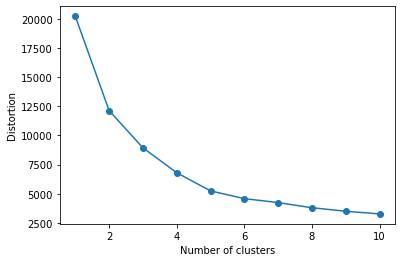

In [55]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt


# km = KMeans(
#     n_clusters=3, init='random',
#     n_init=10, max_iter=300, 
#     tol=1e-04, random_state=0
# )
# y_km = km.fit_predict(X)

distortions = []
for i in range(1, 11):
    km = KMeans(
        n_clusters=i, init='random',
        n_init=10, max_iter=300,
        tol=1e-04, random_state=0
    )
    km.fit(cluster_data_pca)
    distortions.append(km.inertia_)

# plot
plt.plot(range(1, 11), distortions, marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Distortion')
plt.show()

In [56]:
km = KMeans(
    n_clusters=5, init='random',
    n_init=10, max_iter=300, 
    tol=1e-04, random_state=0
)
cluster_data_pca['cluster'] = km.fit_predict(cluster_data_pca)
cluster_data['cluster'] = cluster_data_pca['cluster']

In [57]:
for x in range(0,2):
    temp = cluster_data.reset_index()
    cluster_docks = temp[temp['cluster'] == x]['short_name'].to_list()
    print("{} docks in cluster {}".format(len(cluster_docks), x))

    cluster_docks.append('time')
    print('{:.2%} weekday trips start from docks in this cluster'.format(temp[temp['cluster'] == x]['start_proportion_wd'].sum()))
    print('{:.2%} weekday trips end at docks in this cluster'.format(temp[temp['cluster'] == x]['end_proportion_wd'].sum()))

    print('{:.2%} weekend trips start from docks in this cluster'.format(temp[temp['cluster'] == x]['start_proportion_we'].sum()))
    print('{:.2%} weekend trips end at docks in this cluster'.format(temp[temp['cluster'] == x]['end_proportion_we'].sum()))

#     print(weekday_dock_capacity[cluster_docks])
    fig = px.line(weekday_dock_capacity[cluster_docks], 
                  x="time", 
                  y=weekday_dock_capacity[cluster_docks].columns, 
    #               color_discrete_sequence=['gray'],
    #               width=1,
    #               hover_data={"time": "|"},
                  title='Weekday Station Capacity cluster {}'.format(x))
    fig.update_traces(line=dict(color="Black", width=0.5))

    # fig.update_xaxes(
    #     dtick="M1",
    #     tickformat="%b\n%Y")
    fig.show()
    

    
#     print(weekday_dock_capacity[cluster_docks])
    fig = px.line(weekend_dock_capacity[cluster_docks], 
                  x="time", 
                  y=weekend_dock_capacity[cluster_docks].columns, 
    #               color_discrete_sequence=['gray'],
    #               width=1,
    #               hover_data={"time": "|"},
                  title='Weekend Station Capacity cluster {}'.format(x))
    fig.update_traces(line=dict(color="Black", width=0.5))

    # fig.update_xaxes(
    #     dtick="M1",
    #     tickformat="%b\n%Y")
    fig.show()

60 docks in cluster 0
25.00% weekday trips start from docks in this cluster
24.79% weekday trips end at docks in this cluster
27.92% weekend trips start from docks in this cluster
27.75% weekend trips end at docks in this cluster


58 docks in cluster 1
34.72% weekday trips start from docks in this cluster
34.89% weekday trips end at docks in this cluster
28.30% weekend trips start from docks in this cluster
28.50% weekend trips end at docks in this cluster


In [58]:
for x in range(2,5):
    temp = cluster_data.reset_index()
    cluster_docks = temp[temp['cluster'] == x]['short_name'].to_list()
    print("{} docks in cluster {}".format(len(cluster_docks), x))

    cluster_docks.append('time')
    print('{:.2%} weekday trips start from docks in this cluster'.format(temp[temp['cluster'] == x]['start_proportion_wd'].sum()))
    print('{:.2%} weekday trips end at docks in this cluster'.format(temp[temp['cluster'] == x]['end_proportion_wd'].sum()))

    print('{:.2%} weekend trips start from docks in this cluster'.format(temp[temp['cluster'] == x]['start_proportion_we'].sum()))
    print('{:.2%} weekend trips end at docks in this cluster'.format(temp[temp['cluster'] == x]['end_proportion_we'].sum()))

#     print(weekday_dock_capacity[cluster_docks])
    fig = px.line(weekday_dock_capacity[cluster_docks], 
                  x="time", 
                  y=weekday_dock_capacity[cluster_docks].columns, 
    #               color_discrete_sequence=['gray'],
    #               width=1,
    #               hover_data={"time": "|"},
                  title='Weekday Station Capacity cluster {}'.format(x))
    fig.update_traces(line=dict(color="Black", width=0.5))

    # fig.update_xaxes(
    #     dtick="M1",
    #     tickformat="%b\n%Y")
    fig.show()
    

    
#     print(weekday_dock_capacity[cluster_docks])
    fig = px.line(weekend_dock_capacity[cluster_docks], 
                  x="time", 
                  y=weekend_dock_capacity[cluster_docks].columns, 
    #               color_discrete_sequence=['gray'],
    #               width=1,
    #               hover_data={"time": "|"},
                  title='Weekend Station Capacity cluster {}'.format(x))
    fig.update_traces(line=dict(color="Black", width=0.5))

    # fig.update_xaxes(
    #     dtick="M1",
    #     tickformat="%b\n%Y")
    fig.show()

93 docks in cluster 2
17.63% weekday trips start from docks in this cluster
17.93% weekday trips end at docks in this cluster
20.16% weekend trips start from docks in this cluster
20.43% weekend trips end at docks in this cluster


65 docks in cluster 3
4.67% weekday trips start from docks in this cluster
4.58% weekday trips end at docks in this cluster
4.95% weekend trips start from docks in this cluster
4.93% weekend trips end at docks in this cluster


122 docks in cluster 4
17.07% weekday trips start from docks in this cluster
16.85% weekday trips end at docks in this cluster
17.99% weekend trips start from docks in this cluster
17.61% weekend trips end at docks in this cluster


/Users/mckenziehumann/opt/anaconda3/envs/BigData21/lib/python3.9/site-packages/plotly/express/_core.py:1222: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`



In [ ]:
cluster_data = cluster_data.merge(station_info, on='short_name',how='left')


In [66]:
cluster_data[['cluster','new']].value_counts().to_frame(name='stations').reset_index().sort_values(by=['cluster','new'])

cluster    new  stations
6        0  False        38
7        0   True        22
4        1  False        42
8        1   True        16
5        2  False        39
1        2   True        54
9        3  False        15
2        3   True        50
3        4  False        50
0        4   True        72

In [ ]:
cluster_data.to_csv("../../data/bluebikes/cluster_data.csv")

In [ ]:
cluster_data = cluster_data.merge(station_info[['legacy_id','short_name']], on='short_name',how='left')

In [ ]:
trips = trips.merge(cluster_data[['legacy_id','cluster']],left_on='start station id', right_on='legacy_id',how='left')


In [ ]:
trips = trips.merge(cluster_data[['legacy_id','cluster']],left_on='end station id', right_on='legacy_id',how='left')


In [ ]:
trips = trips.rename(columns={'cluster_x':'start_cluster','cluster_y':'end_cluster'})
trips_gen = trips[trips['gender']!=0].copy()

In [ ]:
cluster_groups = trips_gen.groupby(['start_cluster','end_cluster']).size().to_frame(name='count').reset_index()
cluster_gen_groups = trips_gen.groupby(['start_cluster','end_cluster','gender']).size().to_frame(name='gen_count').reset_index()

In [ ]:
cluster_starts = trips.groupby(['start_cluster']).size().to_frame(name='total_count').reset_index()

In [ ]:

cluster_groups = cluster_groups.merge(cluster_gen_groups, on=['start_cluster', 'end_cluster'])
print(cluster_groups.columns)
cluster_groups = cluster_starts.merge(cluster_groups, on='start_cluster')
print(cluster_groups.columns)
cluster_groups['perc'] = cluster_groups['count'] / cluster_groups['total_count']
cluster_groups['perc_gender'] = cluster_groups['gen_count'] / cluster_groups['count']

In [ ]:
cluster_groups[:50]

In [ ]:
trips['gender'].value_counts()